In [6]:
import process 
import pandas as pd
import numpy as np


# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
# Jerome path : 'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DATA_Statapp.csv'
# Mohamed path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv')

# Apply conversion function to 'open' and 'close' columns
df['open'] = df['open'].apply(process.safe_literal_eval)
df['close'] = df['close'].apply(process.safe_literal_eval)

# Calculate returns for each line
df['return'] = df.apply(lambda row: [(close - open) / open for open, close in zip(row['open'], row['close'])], axis=1)

new_df = df[['ticker', 'return']] # create a new data frame with the column ticker and return 

# Créons le DataFrame à partir des listes dans 'return'
# On suppose ici que 'new_df' est déjà défini et contient la colonne 'return'

# Convertir chaque liste dans la colonne 'return' en plusieurs colonnes dans le nouveau DataFrame
returns_df = pd.DataFrame(new_df['return'].tolist())

# Ajouter la colonne 'ticker' du 'new_df' au début de 'returns_df'
returns_df.insert(0, 'ticker', new_df['ticker'])

# Renommer les colonnes pour refléter qu'elles sont des rendements
returns_df.columns = ['ticker'] + [f'return_{i}' for i in range(len(returns_df.columns) - 1)]

df_cleaned = process.remove_rows_with_nan(returns_df)
df_cleaned.reset_index(drop=True, inplace=True)

process.check_nan_inf(df_cleaned)

df_cleaned.set_index('ticker', inplace=True) ## ces deux lignes sont fondamentales, ne pas les retirer !!
df.set_index('ticker', inplace=True)

There are no NaN values in the dataframe


In [12]:
import warnings 

warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

lookback_window = [3000, 3250]
number_of_clusters = 20
sigma = 2
clustering_method = 'signed_laplacian' 
number_of_repetition = 30
evaluation_window = 10
PnL = []
overall_return = pd.DataFrame()
portfolio_value=[1] #we start with a value of 1, the list contain : the porfolio value at the start of each evaluation period

for i in range(1, 16):

    consolidated_W = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, df=df)

    portfolio_return = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window, consolidated_W=consolidated_W)

    overall_return = pd.concat([overall_return, portfolio_return])

    lookback_window = [lookback_window[0] + evaluation_window*i, lookback_window[1] + evaluation_window*i]

    PnL = np.concatenate((PnL, np.reshape(np.cumprod(1 + portfolio_return)*portfolio_value[-1] - portfolio_value[-1], (evaluation_window,))))## car on réinvestit immédiatement après
    portfolio_value.append(portfolio_value[-1]+PnL[-1])
    print('*'*i)
    print(portfolio_value[-1])
        

*
0.99739902212343
**
1.0171895606452608
***
1.0145494026383008
****
1.0191566170724735
*****
1.022324522650154
******
1.0230677192069257
*******
1.0564299580436936
********
1.0403800197747923
*********
1.0491876344178261
**********
1.0645400001824958
***********
1.0752815799441644
************
1.084956328370519
*************
1.0895023297818536
**************
1.0897277650817965
***************
1.0988931946229121


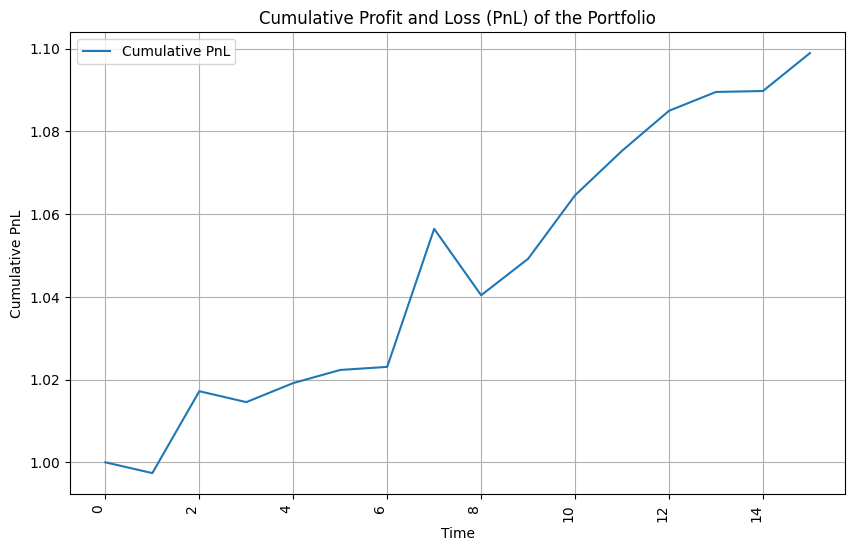

In [14]:
import matplotlib.pyplot as plt 

# Tracé du PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Cumulative PnL')
plt.title('Cumulative Profit and Loss (PnL) of the Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)

plt.xticks(rotation=90, ha='right')

plt.show()


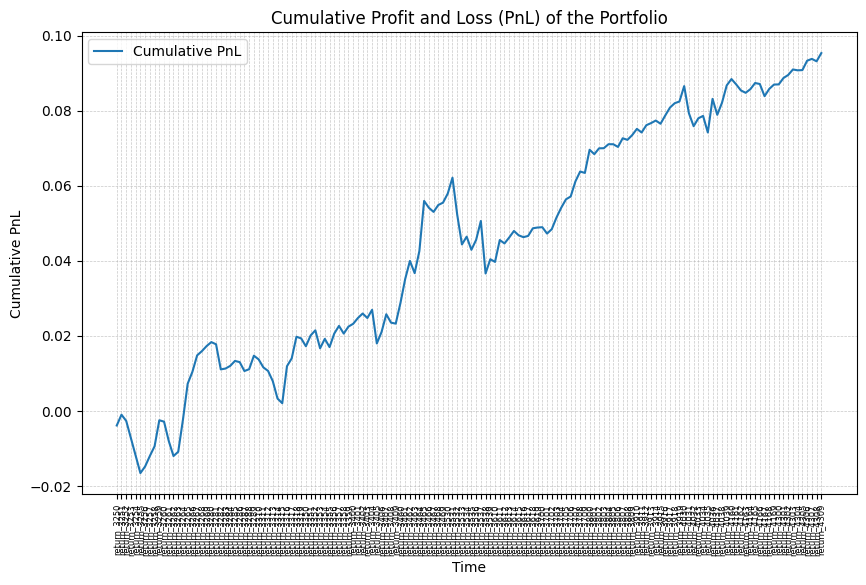

In [21]:
import matplotlib.pyplot as plt 

# Tracé du PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(overall_return.cumsum(), label='Cumulative PnL')
plt.title('Cumulative Profit and Loss (PnL) of the Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)

plt.xticks(rotation=90)
plt.xticks(fontsize=6)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [4]:
corr_matrix = process.correlation_matrix(lookback_window=lookback_window, df_cleaned=df_cleaned)
cluster_composition = process.cluster_composition_and_centroid(df_cleaned=df_cleaned, correlation_matrix=corr_matrix, number_of_clusters=20, lookback_window=lookback_window)
constituent_weights = process.constituent_weights(df_cleaned=df_cleaned, cluster_composition=cluster_composition, sigma=10, lookback_window=lookback_window)
cluster_returns = process.cluster_return(constituent_weights=constituent_weights, df_cleaned=df_cleaned, df=df, lookback_window=lookback_window)

In [11]:
## on construit la matrice de corrélation associée à ces returns, c'est donc une matrice de corrélation de return de cluster

cov_matrix = cluster_returns.transpose().cov()

## on construit le vecteur d'expected return du cluster (250 jours de trading par an, on passe de rendements journaliers à rendements annualisés)
expected_returns = (cluster_returns.mean(axis=1) + 1)**250 - 1 ## on fait ici le choix de prendre le rendement moyen comme objectif

3*((1+ cluster_returns.mean(axis=1))**252 - 1)

cluster 1     0.042149
cluster 2     0.272067
cluster 3      0.06604
cluster 4    -0.785189
cluster 5     -0.42403
cluster 6     0.846191
cluster 7    -0.319651
cluster 8    -0.303905
cluster 9    -0.315543
cluster 10   -0.244019
cluster 11   -0.643756
cluster 12   -0.195504
cluster 13   -0.071217
cluster 14   -1.554415
cluster 15   -0.838066
cluster 16   -0.323671
cluster 17    -0.02103
cluster 18    0.244485
cluster 19    0.213502
dtype: object